In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

This notebook is not properly functioning but as stated in the report, for the future work it can be used. We uploaded and showcased also this to show our efforts and implementation.

In [2]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_size, heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, _ = self.attention(x, x, x, attn_mask=mask)
        x = self.norm1(x + self.dropout(attn_output))
        forward = self.feed_forward(x)
        return self.norm2(x + self.dropout(forward))

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerAutoencoder(nn.Module):
    def __init__(self, embed_size, num_layers, heads, forward_expansion, dropout, latent_size,vocab_size):
        super(TransformerAutoencoder, self).__init__()
        self.embed_size = embed_size

        # Encoder: Stack of Transformer blocks
        self.encoder = nn.ModuleList(
            [
                TransformerBlock(embed_size, heads, forward_expansion, dropout)
                for _ in range(num_layers)
            ]
        )

        # Decoder: Stack of Transformer blocks
        self.decoder = nn.ModuleList(
            [
                TransformerBlock(embed_size, heads, forward_expansion, dropout)
                for _ in range(num_layers)
            ]
        )

        # Fully connected layers for latent space and embedding reconstruction
        self.fc_latent = nn.Linear(embed_size, latent_size)  # Embed size to latent size
        self.fc_embed = nn.Linear(latent_size, embed_size)  # Latent size back to embed size

        # GRU layer for sequence modeling
        self.gru = nn.GRU(embed_size, embed_size, batch_first=True)
        self.fc_out = nn.Linear(embed_size, vocab_size)  # Maps to vocab size for token prediction

        # Positional embeddings
        self.positional_embeddings = self.get_sinusoidal_positional_embeddings(512, embed_size)

    def get_sinusoidal_positional_embeddings(self, max_len, embed_size):
        """
        Generate sinusoidal positional embeddings.
        Args:
            max_len: Maximum sequence length.
            embed_size: Embedding size.
        Returns:
            pos_embeddings: Tensor of shape (max_len, embed_size).
        """
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_size))
        pos_embeddings = torch.zeros(max_len, embed_size)
        pos_embeddings[:, 0::2] = torch.sin(position * div_term)
        pos_embeddings[:, 1::2] = torch.cos(position * div_term)
        return pos_embeddings

    def forward(self, x):
        # Add positional embeddings to input
        # Assuming x has shape [batch_size, sequence_length]
        batch_size, sequence_length = x.size()

        # Positional embeddings with shape [sequence_length, embed_dim]
        pos_emb = self.positional_embeddings[:sequence_length, :].to(x.device)  # Shape: [sequence_length, embed_dim]

        # Expand positional embeddings to match batch size
        pos_emb = pos_emb.unsqueeze(0).expand(batch_size, sequence_length, -1)  # Shape: [batch_size, sequence_length, embed_dim]

        # If x is missing the embedding dimension, unsqueeze to [batch_size, sequence_length, 1]
        x = x.unsqueeze(-1)  # Shape: [batch_size, sequence_length, 1]

        # Add positional embeddings
        x = x + pos_emb

        # Pass through encoder
        for layer in self.encoder:
            x = layer(x)

        # Latent space transformation
        latent = self.fc_latent(x)

        # Project back to embedding space
        x = self.fc_embed(latent)

        # Pass through GRU layer
        x, _ = self.gru(x)

        # Pass through decoder
        for layer in self.decoder:
            x = layer(x)
        #print(f"last shape of x {x.shape}") 8,256,256
        logits = self.fc_out(x)  # Shape: [batch_size, sequence_length, vocab_size]
        return logits, latent


In [6]:
class AttributeLoss(nn.Module):
    def __init__(self):
        super(AttributeLoss, self).__init__()

    def forward(self, q, q_true):
        """
        Args:
            q: Predicted attribute probabilities (batch_size, output_dim)
            q_true: True attribute probabilities (batch_size, output_dim)
        """
        # The negative log likelihood loss
        loss = -(q_true * torch.log(q)).sum(dim=-1)  # Sum over the attribute dimension
        return loss.mean()  # Average over the batch
import torch
import torch.nn as nn

class ReconstructionLoss(nn.Module):
    def __init__(self, vocab_size, epsilon=0.1):
        """
        Args:
            vocab_size: Size of the output vocabulary.
            epsilon: Smoothing parameter for label smoothing.
        """
        super(ReconstructionLoss, self).__init__()
        self.vocab_size = vocab_size
        self.epsilon = epsilon
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction='none')  # Cross-entropy loss without reduction

    def forward(self, outputs, targets):
        """
        Args:
            outputs: Predicted logits (batch_size, seq_len, vocab_size).
            targets: Ground truth class indices (batch_size, seq_len).

        Returns:
            loss: Scalar reconstruction loss with smoothing.
        """
        # Flatten outputs and targets for CrossEntropyLoss
        outputs = outputs.view(-1, 30522)  # Shape: (batch_size * seq_len, vocab_size)
        targets = targets.view(-1)  # Shape: (batch_size * seq_len)
        targets = targets.clamp(0, 30521)  # Clamp target values to valid range

        # Compute cross-entropy loss
        ce_loss = self.cross_entropy_loss(outputs, targets)  # Shape: (batch_size * seq_len)

        # Uniform smoothing term
        with torch.no_grad():
            uniform_dist = torch.full_like(outputs, 1.0 / 30522)  # Shape: (batch_size * seq_len, vocab_size)
        smoothing_loss = (uniform_dist * torch.softmax(outputs, dim=-1)).sum(dim=-1)  # Shape: (batch_size * seq_len)

        # Combine cross-entropy and smoothing terms
        total_loss = (1 - self.epsilon) * ce_loss + self.epsilon * smoothing_loss

        # Return the mean loss
        return total_loss.mean()


In [7]:
# Classifier
class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.linear1 = nn.Linear(input_size, 100)
        self.linear2 = nn.Linear(100, 50)
        self.output = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.output(x)
        return self.sigmoid(x)

In [8]:
def fast_gradient_iterative_modification(z, classifier, y_prime, weights, decay_coeff, threshold, s_steps):
    z_star = z.clone()
    for w_i in weights:
        for step in range(s_steps):
            z_star.requires_grad = True
            output = classifier(z_star)
            loss = F.binary_cross_entropy_with_logits(output, y_prime)
            loss.backward()
            grad = z_star.grad
            with torch.no_grad():
                z_star -= w_i * grad
                pred = torch.sigmoid(classifier(z_star))
                if torch.abs(y_prime - pred).mean() < threshold:
                    return z_star
            w_i *= decay_coeff
            z_star.grad.zero_()
    return z_star

In [9]:
# Hyperparameters
embed_size = 256
vocab_size = 30522 # BERT tokenizer vocab size
latent_size = 256
num_layers = 2
heads = 8
forward_expansion = 4
dropout = 0.1
hidden_size = 128
batch_size = 128
num_classes = 10  # Example number of classes
smoothing = 0.1
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



DATASET


In [10]:
# @title
import re
import os

# Define the path to your files
folder_path = '/kaggle/input/obama-trump'

file_names = ['Trump.txt', 'Obama.txt']

contents = {}

for file_name in file_names:
  file_path = os.path.join(folder_path, file_name)
  if os.path.exists(file_path):
    with open(file_path, 'r') as file:
      content = file.read()
      contents[file_name] = content
  else:
    print(f"File '{file_name}' not found in the specified directory.")

In [11]:
# @title
def preprocess_trump_text_debug(text):
    print(f"Original word count: {len(text.split())}")

    # 1. Remove "Q:" and "President:" markers
    text = re.sub(r'(Q:|President:)', '', text)
    print(f"After removing markers: {len(text.split())}")

    # 2. Remove stage directions (e.g., "(Applause)")
    text = re.sub(r'\(.*?\)', '', text)
    print(f"After removing stage directions: {len(text.split())}")

    # 3. Standardize line breaks
    text = re.sub(r'(?<!\n)\n(?!\n)', ' ', text)  # Replace single newlines with space
    print(f"After standardizing single line breaks: {len(text.split())}")
    text = re.sub(r'\n{2,}', '\n', text)          # Retain paragraph breaks
    print(f"After standardizing paragraph breaks: {len(text.split())}")

    # 4. Remove redundant repetitions
    text = re.sub(r'\b(\w+)(?: \1\b)+', r'\1', text)
    print(f"After removing redundant repetitions: {len(text.split())}")

    # 5. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    print(f"After normalizing whitespace: {len(text.split())}")

    return text

def preprocess_obama_text_debug(text):
    """
    Preprocesses text data by cleaning markers, removing stage directions,
    standardizing line breaks, and normalizing repetitions, with debugging outputs.

    Parameters:
        text (str): Input raw text.

    Returns:
        str: Cleaned and preprocessed text.
    """
    # Original word count
    print(f"Original word count: {len(text.split())}")

    # 1. Remove audience reactions (e.g., "(Applause)", "(Laughter)")
    text = re.sub(r'\(.*?\)', '', text)
    print(f"After removing audience reactions: {len(text.split())}")

    # 2. Remove speaker labels (e.g., "THE PRESIDENT:", "AUDIENCE:")
    text = re.sub(r'^(THE PRESIDENT:|AUDIENCE:)', '', text, flags=re.MULTILINE)
    print(f"After removing speaker labels: {len(text.split())}")

    # 3. Standardize line breaks
    text = re.sub(r'(?<!\n)\n(?!\n)', ' ', text)  # Replace single newlines with space
    print(f"After replacing single line breaks: {len(text.split())}")
    text = re.sub(r'\n{2,}', '\n', text)          # Retain paragraph breaks
    print(f"After retaining paragraph breaks: {len(text.split())}")

    # 4. Remove redundant repetitions (e.g., "Thank you. Thank you." → "Thank you.")
    text = re.sub(r'\b(\w+)(?: \1\b)+', r'\1', text)
    print(f"After removing redundant repetitions: {len(text.split())}")

    # 5. Normalize whitespace (e.g., excessive spaces)
    text = re.sub(r'\s+', ' ', text).strip()
    print(f"After normalizing whitespace: {len(text.split())}")

    return text

In [12]:
# @title
print("Trump: ")
proccessed_trump = preprocess_trump_text_debug(contents['Trump.txt'])
print("Obama: ")
proccessed_obama = preprocess_obama_text_debug(contents['Obama.txt'])


Trump: 
Original word count: 65749
After removing markers: 65562
After removing stage directions: 65526
After standardizing single line breaks: 65526
After standardizing paragraph breaks: 65526
After removing redundant repetitions: 65519
After normalizing whitespace: 65519
Obama: 
Original word count: 58033
After removing audience reactions: 57502
After removing speaker labels: 57491
After replacing single line breaks: 57491
After retaining paragraph breaks: 57491
After removing redundant repetitions: 57485
After normalizing whitespace: 57485


In [13]:
# @title
trump = proccessed_trump.split(".")
obama = proccessed_obama.split(".")

In [14]:
# @title
data = []
for sentence in trump:
    data.append({"text": sentence, "style": 1})
for sentence in obama:
    data.append({"text": sentence, "style": 0})



In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer  # If you want to use a pretrained tokenizer like BERT, GPT, etc.
tokenizer_name="bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
class SpeechDataset(Dataset):
    def __init__(self, data, tokenizer_name="bert-base-uncased"):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']
        style = self.data[idx]['style']

        # Tokenizing the text using the tokenizer
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=256, return_tensors='pt')

        # Returning tokenized input and the style label
        return {
            "input_ids": encoding['input_ids'].squeeze(0),  # Removing the extra batch dimension
            "attention_mask": encoding['attention_mask'].squeeze(0),  # If you need attention mask for your model
            "labels": torch.tensor(style, dtype=torch.long)  # Convert the style to a tensor
        }

dataset = SpeechDataset(data)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from tqdm import tqdm


In [17]:
# Loss function and optimizer
autoencoder = TransformerAutoencoder(embed_size, num_layers, heads, forward_expansion, dropout, latent_size,vocab_size).to(device)
classifier = Classifier(latent_size).to(device)

reconstruction_criterion = ReconstructionLoss(vocab_size=batch_size, epsilon=smoothing)
classifier_criterion = AttributeLoss()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)
classifier.to(device)

Classifier(
  (linear1): Linear(in_features=256, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [18]:
reconstruction_losses = []
classification_losses = []


In [19]:
# Define the optimizers for the two components
autoencoder_optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-7)
classifier_optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-7)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    epoch_reconstruction_loss = 0.0
    epoch_classification_loss = 0.0
    # ----------------------
    # Phase 1: Train Autoencoder
    # ----------------------
    autoencoder.train()
    classifier.eval()  # Freeze classifier during autoencoder training
    i = 0
    print("Optimizing autoencoder")
    for batch in dataloader:
        i += 1
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        # Zero the gradients for autoencoder
        autoencoder_optimizer.zero_grad()

        # Forward pass through the autoencoder
        reconstructed_outputs, latent_representation = autoencoder(input_ids)

        # Forward pass through the classifier (only for loss calculation)
        with torch.no_grad():
            attribute_predictions = classifier(latent_representation)

        # Compute reconstruction loss
        reconstruction_loss = reconstruction_criterion(reconstructed_outputs, input_ids)

        # Compute classification loss (but don't optimize it here)
        classification_loss = classifier_criterion(attribute_predictions, labels)
        
        epoch_reconstruction_loss += reconstruction_loss.item()
        epoch_classification_loss += classification_loss.item()
        
        # Backpropagate and update the autoencoder's weights
        reconstruction_loss.backward()
        autoencoder_optimizer.step()

        if i % 200 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Step {i}, Reconstruction Loss: {reconstruction_loss.item():.4f}, Classification Loss: {classification_loss.item():.4f}")

    # ----------------------
    # Phase 2: Train Classifier
    # ----------------------
    classifier.train()
    autoencoder.eval()  # Freeze autoencoder during classifier training
    i = 0
    print("Optimizing the classifier")
    for batch in dataloader:
        i += 1
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass through the autoencoder to get latent representation
        with torch.no_grad():  # Freeze the autoencoder during classifier training
            reconstructed_outputs, latent_representation = autoencoder(input_ids)

        # Forward pass through the classifier
        attribute_predictions = classifier(latent_representation)

        # Compute reconstruction loss (but don't optimize it here)
        reconstruction_loss = reconstruction_criterion(reconstructed_outputs, input_ids)
        
        # Compute classification loss
        classifier_optimizer.zero_grad()
        classification_loss = classifier_criterion(attribute_predictions, labels)

        epoch_reconstruction_loss += reconstruction_loss.item()
        epoch_classification_loss += classification_loss.item()
        
        # Backpropagate and update the classifier's weights
        classification_loss.backward()
        classifier_optimizer.step()
    
        if i % 200 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Step {i}, Reconstruction Loss: {reconstruction_loss.item():.4f}, Classification Loss: {classification_loss.item():.4f}")
    # Calculate average losses for the epoch
    avg_reconstruction_loss = epoch_reconstruction_loss / len(dataloader)/2
    avg_classification_loss = epoch_classification_loss / len(dataloader)/2

    # Store losses
    reconstruction_losses.append(avg_reconstruction_loss)
    classification_losses.append(avg_classification_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Avg Reconstruction Loss: {avg_reconstruction_loss:.4f}, Avg Classification Loss: {avg_classification_loss:.4f}")

Optimizing autoencoder
Epoch 1/10, Step 200, Reconstruction Loss: 9.5552, Classification Loss: 3.5041
Epoch 1/10, Step 400, Reconstruction Loss: 9.2460, Classification Loss: 4.1913
Epoch 1/10, Step 600, Reconstruction Loss: 8.9102, Classification Loss: 4.8880
Epoch 1/10, Step 800, Reconstruction Loss: 8.5400, Classification Loss: 3.5050
Epoch 1/10, Step 1000, Reconstruction Loss: 8.2426, Classification Loss: 2.7933
Optimizing the classifier
Epoch 1/10, Step 200, Reconstruction Loss: 8.1463, Classification Loss: 2.7899
Epoch 1/10, Step 400, Reconstruction Loss: 8.1360, Classification Loss: 3.4865
Epoch 1/10, Step 600, Reconstruction Loss: 8.1329, Classification Loss: 4.8819
Epoch 1/10, Step 800, Reconstruction Loss: 8.1139, Classification Loss: 4.1782
Epoch 1/10, Step 1000, Reconstruction Loss: 8.1630, Classification Loss: 5.5510
Epoch 1/10, Avg Reconstruction Loss: 8.6158, Avg Classification Loss: 3.4643
Optimizing autoencoder
Epoch 2/10, Step 200, Reconstruction Loss: 7.9550, Classifi

In [23]:
classification_losses

[3.464295526153236,
 3.444582500162337,
 3.4228392435239567,
 3.397300554152726,
 3.3663109012113996,
 3.330024323701166,
 3.2891011394755076,
 3.2456209433967356,
 3.1998763511395523,
 3.152612577911037]

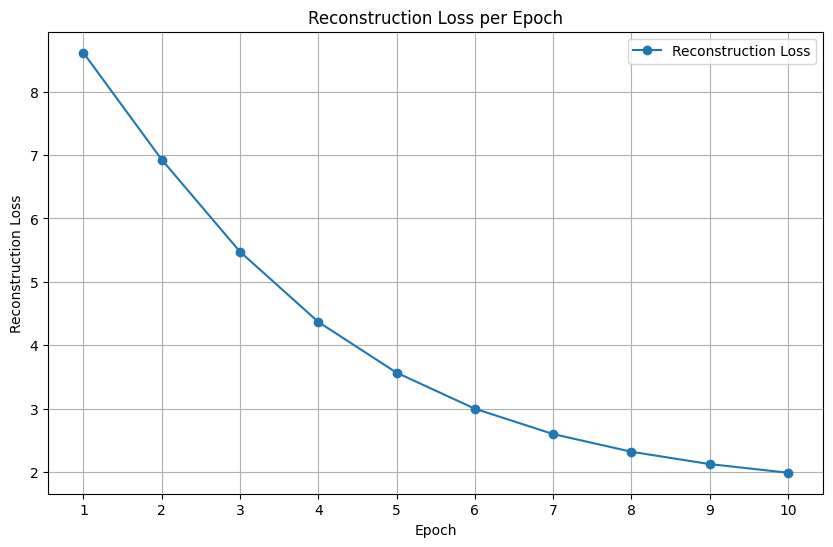

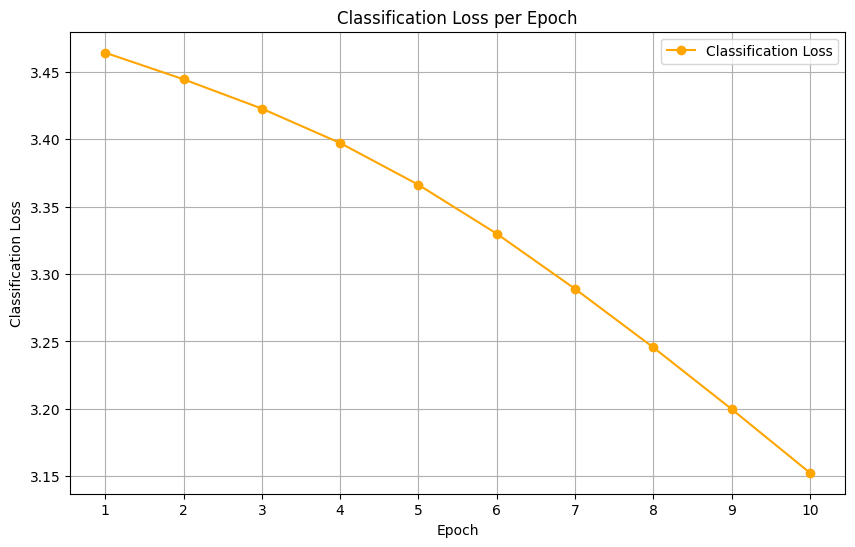

In [24]:
import matplotlib.pyplot as plt
# Plotting Reconstruction Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), reconstruction_losses, label='Reconstruction Loss', marker='o')
plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis only has integer epoch values
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

# Plotting Classification Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), classification_losses, label='Classification Loss', marker='o', color='orange')
plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis only has integer epoch values
plt.xlabel('Epoch')
plt.ylabel('Classification Loss')
plt.title('Classification Loss per Epoch')
plt.legend()
plt.grid()
plt.show()


In [30]:
# Example data
data = [
    {"text": "This is an example sentence.", "style": 0},
    {"text": "Another example with different style.", "style": 1}
]

# Create the dataset and DataLoader
dataset = SpeechDataset(data)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Example: Iterating through the DataLoader
for batch in dataloader:
    input_ids = batch['input_ids'].to('cpu')
    
    # Get the reconstructed output from the autoencoder
    reconstructed_outputs, _ = autoencoder.to('cpu')(input_ids)
    
    # Assuming reconstructed_outputs are logits, apply softmax to get probabilities
    reconstructed_outputs = torch.softmax(reconstructed_outputs, dim=-1)
    print(reconstructed_outputs.shape)
    # Convert logits/probabilities to token IDs (take the argmax across the vocab size dimension)
    token_ids = torch.argmax(reconstructed_outputs, dim=-1)  # Shape: [batch_size, seq_len]
    print(token_ids.shape)
    # Convert token_ids to text using the tokenizer
for token in token_ids:
    reconstructed_text = tokenizer.decode(token.squeeze(0), skip_special_tokens=True)  # Remove batch dimension if necessary
    print(f"Reconstructed Text: {reconstructed_text}")



torch.Size([2, 256, 30522])
torch.Size([2, 256])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Reconstructed Text: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
test_text = ["A new sentence to classify."]

# Prepare the dataset for the test
test_data = [{"text": text, "style": None} for text in test_text]
test_dataset = SpeechDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example: Inference loop
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No gradients needed for inference
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Get predictions from the model
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.argmax(dim=-1)  # Get the predicted class label
        print(f"Predicted Style: {predictions.item()}")
